# Floating Point numbers
1. Integers
2. Fixed point
3. Floating point
4. Questions
    

## Integers

In [14]:
for i in range(16):
    print(f"{i:2} {i:04b}")

 0 0000
 1 0001
 2 0010
 3 0011
 4 0100
 5 0101
 6 0110
 7 0111
 8 1000
 9 1001
10 1010
11 1011
12 1100
13 1101
14 1110
15 1111


### Negative integers
- The most significant bit indicates if a value is negative
- However, negating a number is not as simple as flipping this bit
- Negative numbers are stored in something called two's complement

In [49]:
a = -6
f"{a:04b}"

'-110'

In [47]:
[format(b, '8b') for b in (-6).to_bytes(signed=True)]

['11111010']

In [63]:
print(0b1111010)  # format above as decimal
print(0b0111010)  # mask out top bit - It's not 6!

122
58


In [64]:
0b1111010
122 - (1 << (8-1))

-6

## Fixed point

What if we want to store half-numbers as well, like 17.5?

In [122]:
# Just the number 17
a = 17 
print(f"{a:08b} {a} just 17")

# let's use the least significant bit for halves!
a = a << 1
print(f"{a:08b} {a} shifted one step")

# make it 17.5
a += 1
print(f"{a:08b} {a} 17.5")

# let's add a with a
b = a + a
print(f"{b:08b} {b} 17.5 + 17.5 shifted one step to the left")

# let's shift back to int. The "half-indicator bit" is dropped
b = b >> 1
print(f"{b:08b} {b} 17.5 + 17.5 rounded to closest int")

00010001 17 just 17
00100010 34 shifted one step
00100011 35 17.5
01000110 70 17.5 + 17.5 shifted one step to the left
00100011 35 17.5 + 17.5 rounded to closest int


### Interlude - Quick recap on bit masks

In [102]:
# Quick recap on bit masks
print(f"{1 << 3:08b}")
print(f"{(1 << 3) - 1:08b}")

00001000
00000111


In [106]:
a = 17
mask = (1 << 3) - 1
print(f"{a:08b}")
print(f"{mask:08b}")
print(f"{a & mask:08b}")

00010001
00000111
00000001


In [127]:
# The same reasoning can be extended to quarters by shifting two steps, etc. In general we can shift EXPONENT step
EXPONENT = 4
Fixed = int
def to_fixed(value: float) -> Fixed:
    i = int(value)  # integer part
    f = value - i  # fraction part
    return (i << EXPONENT) + int(f * (1 << EXPONENT))

def to_float(fixed: Fixed) -> float:
    mask = (1 << EXPONENT) - 1
    return (fixed >> EXPONENT) + (fixed & mask) / (1 << (EXPONENT))

start = 17.75
fixed = to_fixed(start)
end = to_float(fixed)
print(start, fixed, end)

17.75 284 17.75


### Multiplication
When multiplying fixed point numbers, things get slightly more tricky.

In [134]:
a = to_fixed(2.0)
b = to_fixed(3.0)
to_float(a * b)  # something is not right, we should get 6?

96.0

$$a=2$$
$$b=3$$
$$a_{fixed} = 32 = a2^{-4}$$
$$b_{fixed} = 48 = b2^{-4}$$
$$a_{fixed}b_{fixed} = ab2^{-8}$$

In [136]:
def fixed_mul(a: Fixed, b: Fixed) -> Fixed:
    # first shift operands by half of the exponent
    e0 = EXPONENT // 2
    e1 = EXPONENT - e0
    return (a >> e0) * (b >> e1)

a = to_fixed(2.0)
b = to_fixed(3.0)
to_float(fixed_mul(a, b))

6.0

## Floating points
* Stores a variable exponent together with the number value and sign bit.
* Standardized under IEEE 754.
* Also specifies operations and more
* Allows for higher range of numbers to be expressed
* Multiple variants excists for half-precision, double and quad precision as well
* Can be slow without deidcated hardware


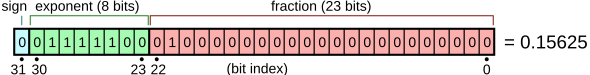

## Evaluation
$$(-1)^s * 2^{exponent-127} * (1 + fraction)$$

In [173]:
import struct
def float_bits(num: float) -> str:
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

def print_parts(num: float):
    bits = float_bits(num)
    print('number', num)
    print('bits', bits)
    print('sign', bits[0], int(bits[0], 2))
    print('exponent', bits[1:9], int(bits[1:9], 2))
    print('fraction', bits[9:32], int(bits[9:32], 2))    
    sign = int(bits[0], 2)
    exponent = int(bits[1:9], 2)
    fraction = int(bits[9:32], 2) / (1 << 23)
    print('evaluation', (-1)**sign * 2 ** (exponent - 127) * (1 + fraction))

print_parts(0.15625)

number 0.15625
bits 00111110001000000000000000000000
sign 0 0
exponent 01111100 124
fraction 01000000000000000000000 2097152
evaluation 0.15625


### Subnormal numbers
- Numers are always stored on _normal_ form where there are no leading zeroes in the fraction part.
- However, for sufficently small numbers this is not possible (when the exponent is already maxed out)
- This is encoded as the exponent having it's lowest possible value (0), while the fraction part is non-zero

### Infinites
* Encoded as all ones for the exponent (for eample 256 for 8-bit exponent) and the fraction being _zero_.
* There are thus only two infinites $-\infty$ and $\infty$.

### Not A Number (NAN)
- Encoded as all ones for the exponent (for eample 256 for 8-bit exponent) and the fraction being _non-zero_.
- Used to store results 
- There are thus many NANs as the fraction part can by any non-zero value.
- Also the sign is normally ignored and can also be used to store data.

In [176]:
print_parts(float('nan'))

number nan
bits 01111111110000000000000000000000
sign 0 0
exponent 11111111 255
fraction 10000000000000000000000 4194304
evaluation 5.104235503814077e+38


## Questions